<a href="https://colab.research.google.com/github/tamburins/ESAA_2023/blob/main/ESAA_5_19(591_624).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://grouplens.org/datasets/movielens/latesu/

## 06 아이템 기반 최근접 이웃 협업 필터링 실습

최근접 이웃 협업 필터링은 사용자기반, 아이템기반으로 분류되며 일반적으로 추천정확도가 높은 아이템 기반의 협업필터링을 구현해보자. 사용자가 영화의 평점을 매긴 사용자-영화 평점 행렬 데이터세트를 다운하자.

### 데이터 가공 및 변환


In [6]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


rating 파일은 사용자별 영화에 대해 평점을 매긴 데이터로 사용자아이디, 영화이아이디, 평점인 칼럼으로 구성된다. 

협업필터링은 이 rating_Csv 데이터 세트와 같이 사용자와 아이템간의 평점에 기반해 추천해주는 시스템으로 아이템 기반의 최근접 이웃 협업 필터ㅣㄹㅇ을 구현해보자. 먼저 행 레벨 형태의 원본데이터세트를 행별로 사용자가 들어가며 열별로 영화가 들어가게 해보자. 피봇테이블 함수를 이용한다.



In [7]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


movie id값이 변환되었다. 변환되면서 난값이 많이 보인다. 최소평점이 0.5이므로 난값은 0으로 모두 변환한다. 다만 죄다 0을 주면 이게 사용자가 찐으로 0을 준건지 아님 난값인지 파악학 ㅣ어렵다

In [8]:
ratings_movies = pd.merge(ratings, movies, on='movieId')
ratings_matrix = ratings_movies.pivot_table('rating',index='userId', columns='title')

# all nan>0
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 영화 간 유사도 산출
코사인 유사도를 이용해야하나 이 데이터프레임의 경우 코사인유사도 메소드 특성상 사요ㅕㅇ자간 유사도를 출력해줌.

그러기 위해서 전치 함수 이용



In [10]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# 전치행렬 형식으 ㅣ데이터세트 기반으로 코사인 유사도 구하기
from sklearn.metrics.pairwise import cosine_similarity
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine similarity로 반환된 행렬을 영화명을 매핑해 데이터프레임으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns, columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


전치 ratigns matrix에 대해 코사인유사도를 적용한 결과 정방행렬 item sim이 생성됨

이를 데이터프레임으로 변환한 행렬을 이용하여 대부와 유사도가 높은 상위 6개 영화를 추출해보자.

In [12]:
item_sim_df['Godfather, The (1972)'].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

기존 영화를 제외하면 대부 2편이 제일 높으며 그 뒤를 이어 좋은 친구들이 잇는다.

앞의 콘텐츠 기반 필터링과 다른 점은 뻐꾸기 둥지 위로 날아간 새, 스타워즈1편과 같이 자을가 완전 다른 영화도 유사도가 매우 높게 나타났다

이번엔 인셉션으로 해보자

In [13]:
item_sim_df['Inception (2010)'].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

다크나이트의 유사도가 제일 높으며 그 뒤를 이어 스릴러와 액션이 가미된 좋은 영화가 높은 유사도를 잇는다.

만들어진 아이템 기반 유사도 데이터는 사용자의 평점정보를 모두 취합해 영화에 따라 유사한 다른 영화를 추천해준다.

이번에는 개인에게 특화된 영화 추천알고리즘을 만들어보자.

### 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천

이번에는 개인적인 취향을 반영할 수 있는 개인에게 최적화디어있는 영화 추천을 구현해보자. 아직 관람하지 않은 영화에 대해 아이템 유사도와 기좆 관람 영화의 평점데이터를 기반으로 모든 영화의 예측평점을 계산한 뒤 높은 예측 평점을 가진 영화를 추천하는 방식이다. 사용자와 아이템의 갱니화된 예측평점값, 아이템과 가장 유사도가 높은 탑 n개 아이템의 유사도벡터, 사용자으 ㅣ아이템과 가장 유사도가 높은 탑 n개 아이템에 대해 실제 평점 벡터를 이용한다.여기서의 N값은 아이템의 최근접 이웃 범위 계수를 의미하는 것으로 특정 아이템과 유사도가 가장 높은 탑n개의 아이템을 추출하는데 사용된다. 먼저 n의 범위에 제약을 두지 않고 모든 아이템으로 가정하고, 예측 평점을 구하는 로직을 작성한 뒤에 탑 n개의 아이템을 기반으로 협업필터링을 수행하는 로직으로 변경한다.

앞 예제에서 생성된 영화간 유사도를 가지는 데이터프레임인 item_sim_df와 사용ㅈ ㅏ영화 평점 데이터프레임인 ratings_matrix 변수를 계속 활용해 사용자별로 최적화된 평점스코어를 예측하는 함수를 생성한다. 인자로 사용자-영화 평점 넘파이 ㅅ행렬을 과 영화간 유사도를 갖는 넘파이행렬을 이 ㅂ력받고 이를 이용해 개인화된 예측 평점을 계산한다.

n의 범위에 제약을 두지 않느다면 사용자별 영화예측 평점은 사용자 u의 모든 영화에 대한 실제평점과 영화 i의 다른 모든 영화와의 코사인 유사도를 벡터내적곱한 값을 정규화를 위해 나눈 것을 의미한다.






In [14]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr)/np.array([np.abs(item_sim_arr).sum(axis=1)])
  return ratings_pred

ratings arr dot은 예측평점의 분자를, np.array(np.abs(item_sim_arr).sum(axis=1)]은 분모를 의미한다.

예측 평점을 구해보자

In [15]:
ratings_pred= predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)

ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


예측 평점이 사용자별 영화의 실제평점과 영화의 코사인 유사도를 내적한 값이기 때문에 기존에 영화를 관람하지 않아 0에 해당했던 실제 영화평점이 예측에서는 값이 부여되는 경우가 많이 밠갱한다. 예측 평점이 실제평점에 비해 작을 수 있다. 이는 내적결과를 코사인 유사도 벡터합으로 나누었기 때문에 발생한다.

이러한 예측결과가 원래으 ㅣ실제평점과 얼마나 차이가 있는지 확인해보자. 예측 평가지표는 mse로 사용자가 영화의 평점을 주지 않은 경우 앞에서는 0을 부여하였으나 앞에서 개인화된 예측 점수는 평점을 주지 않은 영화에 대해서도 아이템 유사도에 기반해 평점을 예측했다. 따라서 실제와 예측 평점의 차이는 기존 평점이 부여된 데이터에 대해서만 오차를 측정한다.

In [16]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 mse를 ㄱㅜ함
def get_mse(pred,actual):
  # extract real ratings
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred, actual)

print('item based all neighbored MSE: ', get_mse(ratings_pred, ratings_matrix.values))

item based all neighbored MSE:  9.895354759094706


MSE가 약 9.89로 실제값과 예측값의 스케일 차이로 발생할 수 있다.

앞의 predict_ratings는 예측평점 계싼을 위해 해당 영화와 모든 다른 영화간으 ㅣ유사도 벡터를 적용했다. 많은 영화의 유사도벡터를 이요하다 보니 상대적으로 평점예측이 떨어졌다. 특정 영화와 가장 비슷한 유사도를 갖는 영화에 대해서만 유사도벡터를 적용하는 함수로 변경한다.

새로 생성한ㄴ 함수는 N인자를 가져 top-n 유사도를 갖는 영화유사도 벡터만 예측값을 계산하는데 적용한다. 아쉬운 걳은 이러한 계산을 ㅜ이해서는 개별 예측값을 구하기 위해 행,열별로 for 루프를 반복 수행하며 유사도벡터를 계산해야하기 떄문에 수행시간이 오래 걸린다.

In [17]:
def predict_ratings_topsim(ratings_arr, item_sim_arr, n=20):
  # 사용자 아이템 평점 행렬의 크기만큼 0으로 채운 예측행렬 초기화
  pred = np.zeros(ratings_arr.shape)

  #사용자 이에템 평점행렬의 열크기만큼 루프 수행
  for col in range(ratings_arr.shape[1]):
    # 유사도가 큰 순으로 n개데이터 해열ㄹ의 인덱스 반환
    top_n_items = [np.argsort(item_sim_arr[:, col])[:n-1:-1]]

    # 개인화된 예측평점 계산
    for row in range(ratings_arr.shape[0]):
      pred[row,col]=item_sim_arr[col, :][top_n_items].dot(ratings_arr[row,:][top_n_items].T)
      pred[row,col]/=np.sum(np.abs(item_sim_arr[col, :][top_n_items]))

  return pred

                                                        

In [18]:
# get mse
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[user_rating_id>0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

오스틴 파워 반지의 제왕 등 대작영화나 어드벤처 영화, 코미디 등 전반적으로 흥행성이 좋은 영화에 높은 평점을 주고 있다. 사용자에게 아이템 기반 협업기반 필터링을 통해 영화를 추천한다. 먼저 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수를 생성한다.

In [19]:
def get_unseen_movies(ratings_matrix, userId):
  # userid로 입력받은 사용자의 모든 여화정보를 추출해 시리즈로 반환
  # 반환된 user rating은 영화명을 인덱스로 가지는 시리즈 객체
  user_rating = ratings_matrix.loc[userId,:]

  # userrating이 0보다 크면 기존 관람한 영화. 대상 인덱스를 추출해 리스트 객체로 만듦
  already_seen = user_rating[user_rating>0].index.tolist()

  # all to list
  movies_list = ratings_matrix.columns.tolist()

  # lsit comprehension으로 already seen에 해당하는 영화는 영화리스트에서 제함
  unseen_list=[movie for movie in movies_list if movie not in already_seen]
  return unseen_list

사용자가 영화의 평점을 주지 않은 추천대상영화정보와 predict rating topsim에서 추출한 사용자별 아이템 유사도에 기반한 예착평점 데이터세트를 이용해 최종적으로 사용자에게 영화를 추천하는 함수를 생성한다. 해당 함수는 예측평점데이터프레임과 추천하려는 사용자 id, 추천후보영화리스트, 추천상위 영화개수를 인자로 받아 사용자가 좋아할만한 가장 노픈 예측평점을 가진 영화를 추천해준다.

In [20]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
  # 예측 평점 데이터프레임에서 사용자아이디 인덱스와 ㅕnseen list로 들어온 영화명 칼럼을 ㅜ출해
  # 가장 예측평점이 높은 순으로 정렬
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
  return recomm_movies

# extract unseen movie
unseen_list = get_unseen_movies(ratings_matrix, 9)

#아이템기반의 최근접 이웃 협업 필엍링으로 영화추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 데이터프레임으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index, columns=['pred_score'])
recomm_movies

,pred_score
title,
Venom (1982),0.303278
Dr. Goldfoot and the Bikini Machine (1965),0.258705
Frankie and Johnny (1966),0.234754
English Vinglish (2012),0.214774
"Harmonists, The (1997)",0.169338
"Passenger, The (Professione: reporter) (1975)",0.163884
"Marriage of Maria Braun, The (Ehe der Maria Braun, Die) (1979)",0.163884
"Child, The (L'enfant) (2005)",0.163884
3:10 to Yuma (1957),0.163884


## 07 행렬 분해를 이용한 잠재요인 협업 필터링 실습

이번에는 행렬분해를 이용한 잠재요인 협업 필터링을 직접 구현해보자. 행렬 분해 잠재요인 협업 필터링은 svd, nmf등을 적용할 수 ㅣㅇㅆ는데, 일반적으로 행렬 분해에는 svd 가 자주 사용되지만 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 널 데이터가 많기 때문에 주로 sgd, als 기반의 행렬분해를 이용한다. 여기서는 sgd 기반의 행렬분해를 구현하고 이를 기반으로 영화를 추천한다.

이번에는 앞과 다르게 행렬분해 로직을 함수로 생성한다

In [21]:
def matrix_factorization(R,K,steps=200, learning_rate=0.01, r_lambda=0.01):
  num_users, num_items = R.shape
  # p,q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤값으로 입력한다.
  np.random.seed(1)
  P = np.random.normal(scale=1./K, size=(num_users, K))
  Q = np.random.normal(scale=1./K, size=(num_items, K))

  prev_rmse = 10000
  break_count = 0

  # where the row is  R>0 > save them in nonzero list
  non_zeros = [ ( i,j,R[i,j]) for i in range(num_users) for j in range(num_items) if R[i, j]>0]

  for step in range(steps):
    for i, j, r in non_zeros:
      eij = r-np.dot(P[i,:], Q[j,:].T)

      P[i, :]=P[i,:]+learning_rate*(eij*Q[j,:]-r_lambda*P[i,:])
      Q[j,:]= Q[j,:] + learning_rate* (eij *  P[i,:]-r_lambda *  Q[j,:])
    
    rmse = get_rmse(R,P, Q, non_zeros)
    if (step%10)==0:
      print('### iteration stop: ', step, "rmse :", rmse)
  return P,Q

In [22]:
# 영화 평점 행렬 데이터 > 사용자 아이ㅁ 평점 핼렬

import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index = 'userId', columns='movieId')
# get title column, join movies
ratings_movies = pd.merge(ratings, movies, on='movieId')
# pivot with title columns ( in columns='title)
ratings_matrix = ratings_movies.pivot_table('rating', index='userId', columns='title')



In [23]:
def get_rmse(R, P, Q, non_zeros):
  error=0
  #두개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix=np.dot(P, Q.T)

  #실제 R 행렬에서 널이 아닌 값의 위치 인덱스를 추출해 실제 R 행렬롸 예측 행렬의 RMSE 추출
  x_non_zero_ind=[non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind=[non_zero[1] for non_zero in non_zeros]
  R_non_zeros=R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros=full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse=mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse=np.sqrt(mse)

  return rmse
     


In [24]:
# 행렬분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda=0.01 )
pred_matrix = np.dot(P,Q.T)

### iteration stop:  0 rmse : 2.9023619751336867
### iteration stop:  10 rmse : 0.7335768591017927
### iteration stop:  20 rmse : 0.5115539026853442
### iteration stop:  30 rmse : 0.37261628282537446
### iteration stop:  40 rmse : 0.2960818299181014
### iteration stop:  50 rmse : 0.2520353192341642
### iteration stop:  60 rmse : 0.22487503275269854
### iteration stop:  70 rmse : 0.2068545530233154
### iteration stop:  80 rmse : 0.19413418783028685
### iteration stop:  90 rmse : 0.18470082002720406
### iteration stop:  100 rmse : 0.17742927527209104
### iteration stop:  110 rmse : 0.1716522696470749
### iteration stop:  120 rmse : 0.16695181946871726
### iteration stop:  130 rmse : 0.16305292191997542
### iteration stop:  140 rmse : 0.15976691929679646
### iteration stop:  150 rmse : 0.1569598699945732
### iteration stop:  160 rmse : 0.15453398186715425
### iteration stop:  170 rmse : 0.15241618551077643
### iteration stop:  180 rmse : 0.1505508073962831
### iteration stop:  190 rmse : 

In [25]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


이렇게 생성된 예측 사용자 아이템 평점 행렬정보를 이용해 개인화된 영화추천을 해보자. 아이템 기반ㅇ 최근접 이웃 협업 필터링 실습과 동일한 잠재요인 협업필터링으로 해보자.

In [26]:
unseen_list = get_unseen_movies(ratings_matrix, 9)

recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9,unseen_list, top_n=9)

recomm_movies = pd.DataFrame(data=recomm_movies, index=recomm_movies.index, columns=['pred_socre'])
recomm_movies

,pred_socre
title,
Rear Window (1954),NaN
"South Park: Bigger, Longer and Uncut (1999)",NaN
Rounders (1998),NaN
Blade Runner (1982),NaN
Roger & Me (1989),NaN
Gattaca (1997),NaN
Ben-Hur (1959),NaN
Rosencrantz and Guildenstern Are Dead (1990),NaN
"Big Lebowski, The (1998)",NaN


앞의 추천 영화와는 다른 영화가 나온다. 훌륭하지만 약간 무겁고 어두운 주제의 영화가 추천되었다.

## 08 파이썬 추천 시스템 패키지 - surprise
### surprise 패키지 소개

지금까지 콘텐츠 기반 필터링, 아이템 기반 협업 필터링, 잡재요인 기반 협업 필터링을 파이선 코드로 구현하였따. 앞에서 다룬 예제코드는 최적화나 수행속도 측면에서 보완이 필요하다. 이번에는 추천시스템 구축을 ㅜ이한 전용 패키지 surprise를 소개한다,

surprise는 conda, pip을 이용해 설치한다

In [27]:
!pip install sckit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sckit-surprise (from versions: none)
ERROR: No matching distribution found for sckit-surprise


In [28]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095453 sha256=8d8dcd86d3872f7920a336908f2a2c56127799d75a5a4306b7642ee780e424de
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


$ conda install -c ocnda-forge scit-surprise

로 설치 가능하다.

이들은 다양한 추천 알고리즘 예를 들어 사용자 또는 아이템기반 최근접 이웃협업필터링, svd, nmf 기반의 잠재요인 협업 필터링을 쉽게 적용해 추천시스템을 구축할 수 있따.

surprise 핵심 api는 사이킷런의 핵심 api와 유사한 api며응로 추천학습 데이터세트와 예측 데이터세트 분리, crossvalidate, 그리드서치cv 클래스를 통해 추천시스템을 위한 모델셀렉샨, 평가 하이퍼파라미터 튜닝등의 기능을 제ㅗㄱ앟ㄴ다.

### surprise 를 이용한 추천 시스템 구축

간단한 예제를 이용하여 패키지의 개략적인 사용법을 익혀보자. 예제는 추천데이터를 학습ㄷ용 데이터와 테스트용 데이터세트로 분리한뒤 행렬분해를 통해 잠재요인 협업 필터링을 수행한다.

In [29]:
from surprise import SVD
from surprise  import Dataset
from surprise  import accuracy
from surprise.model_selection import train_test_split

추천을 위한 데이터세틀ㄹ 로딩하자. 데이터로딩은 dataset클래스를 이용하여 가능하다. 이는 무비렌즈 데이터세트의 사용자-영화평점 데이터포멧과 같이 userid, movie id, rating과 같은 주요데이터가 로우레벨형태로 되어있는 데이터만 처리한다.

surprise는 무비렌즈 사이트에서 제공하는 과거버전의 데이터세트를 가져오는 api를 제공한다. 로딩한 데이터세트를 surprise 피키지의 train_test_split을 이용하여 학습데이터세트와 테스트데이터 세트로 분리해보자.

In [30]:
data = Dataset.load_builtin('ml-100k')
# 수행시마다 동일하게 데이터를 분할하기 위해 randomstatte 값 부여
trainset, testset = train_test_split(data,test_size=25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


처음 load bulitin내의 옵션을 적요알 경우 다음과 같이 무비렌즈 사이트에서 다운받을지를 물어보는데 상자 내에 y를 입력하면 된다.한번 다운받으면 묻지 않고 다운된다.

surprise에서 사용되는 ml 100k 데이터 세트는 앞에서 사용한 파일과 차이가 있다. 과거버전의 데이터세트로  분리문자가 탭문자이다.

surprise에서 사용자-아이템 평점데이터를 적용할 때 주의해야할 점은 무비렌즈 사이트에서 내려받은 데이터파일과 동일하게 로우레벨의 사용자-아이템 평점 데이터를 그대로 적용해야한다는 것이다. 앞에서 로우레벨의 사용자-아이템 평점 데이터를 아이템 아이디를 칼럼명르 ㅗ변환한 형태의 사용자 아이템 평점행렬 데이터로 변환한다. surprise는 자체적으로 로우레벨의 데이터를 칼럼레벨의 데이터로 변경하므로 원본인 로우레벨의 사용자-아이템 평점데이터를 데이터세트로 적용해야 한다.

svd로 잠재요인 협업 필터링을 수행한다. 적용하는 데이터세트는 앞에서 소개한 train_test_split 세트로 분리된 학습데이터세트다. 먼저 algo = svd()와 같이 알고리즘 객채를 생성한다. 이 알고리즘 객체에 fit을 수행해 학습데이터 세트 기반으로 추천 알고리즘을 학습한다.


In [31]:
algo = SVD()
algo.fit(trainset)

학습된 추천알고리즘을 기반으로 테스트 데이터세트에 대해 추천을 수행한다. surprise에서 추천을 예측하는 메서드는 test, predict 두개로 테스트는 사용자-아이템 평점 데이터세트 전체에 대해 추천을 예측하는 메서드이다. 즉 입력된 데이터세트에대해 추천데이터 ㄱ세트를 만들어준다. predict는 개별 사용자와 영화에 대해 추천 평점을 반환한다. 예제를 통해 확인해보자. 테스트데이터세트 전체에 대해 추천영화 평점데이터ㅡㄹ 5개만 반환하는 예제이다.

In [32]:
prediction = algo.test(testset)
print('prediction type: ', type(prediction), 'size: ', len(prediction))
print('prediction 결과의 최초 5개 추출')
prediction[:5]

prediction type:  <class 'list'> size:  25
prediction 결과의 최초 5개 추출


[Prediction(uid='917', iid='50', r_ui=3.0, est=4.285351919658023, details={'was_impossible': False}),
 Prediction(uid='235', iid='318', r_ui=5.0, est=4.4496331541852285, details={'was_impossible': False}),
 Prediction(uid='339', iid='12', r_ui=5.0, est=4.611221294192536, details={'was_impossible': False}),
 Prediction(uid='878', iid='755', r_ui=2.0, est=3.0367309044702986, details={'was_impossible': False}),
 Prediction(uid='618', iid='56', r_ui=4.0, est=3.028131121244263, details={'was_impossible': False})]

svd 알고리즘 객체의 테스트메서드와 호출결과는 파이썬 리스트이며 입력인자 데이터세트와 같은 크기이다. 호출 결과로 반환된 리스트 객체는 25000개의 prediction 객체를 내부에 갖는다. prediction 객체는  surprise 패키지에서 제공하는 데이터타입이며 개별 사용자 아이디, 영화 아이디, 실제평점정보에 기반해 surprise의 추천 예측 평점 데이터를 튜플형태로 갖는다. prediction 객체의 details 속성은 내부 처리시 추천 예측을 할 수 없는 경우에 로그용으로 데이터를 남기는데 사용된다. was impossible이 트루이면 예측값ㅇ르 생성할 수 없는 데이터라는 의미이다.

리스트객체내에 내포된 prediction객체의 uid, id,rui,est등의 속성에 접근하려면 객체명 uid와 같은 형식으로 가능하다. 다음은 prediction 객체에서 uid, iid, est 속성을 추출한 예제에디ㅏ.

In [33]:
[ ( pred.uid, pred.iid, pred.est) for pred in prediction[:3]]

[('917', '50', 4.285351919658023),
 ('235', '318', 4.4496331541852285),
 ('339', '12', 4.611221294192536)]

이번에는 surprise 패키지의 다른 추천 예측 메서드인 predict를 이용해 추천예측을 해보자. predict는 개별 사용자의 아이템에 대한 추천평점을 예측한다.인자로 개별사용자 아이다, 아이템 아이디를 입력하면 추천예측평점을 포함한 정보를 반환한다.

In [34]:
# user id, item id need to input with string
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.00   {'was_impossible': False}


결과처럼 predict()는 개별 사용자와 아이템 정보를 입력하면 추천 예측평점을 est로 반환한다. test 메서드는 입력데이터 세트의 모든 사용자와 아이템 아이디에 대해서 predict()를 반복적으로 수행한 결과라고 생각하면 좀 더 이해하기 쉽다.

테스트 데이터 세트를 이용해 추천예측평점과 실제평점과의 차이를 평가합니다. surprise 의 accuracy 모듈은 rmse, mse 등의 방법으로 추천시스템으 ㅣ성능평가 정보를 제공한다. 

In [35]:
accuracy.rmse(prediction)

RMSE: 0.9019


0.9018963783243569

이처럼 패키지로 손쉽게 추천시스템을 구현할 수 있다. 이제는 ㅐㄴ장데이터 세트가 아닌 다른 데이터파일을 로딩해서 추천시스템을 생성하자. 그 전에 모듈을 좀 더 살펴보자

### surprise 주요 모듈 소개
#### dataset
surprise는 사용자아이디, 아이템아아ㅣ디, 평점이 로우레벨인 것들만 사용할 수 있다. 이렇게 가정하고 네번쨰 칼럼부터는 로딩을 수행하지 않는다. 순서도 고정적이다.

- dataset.load.bulitin(name='ml-100k'): 무비렌즈 아카이브서버에서 무비렌즈 데이터를 내려받는다. 일단 내렵다은 데이ㅓㅌ는 surprise data 디렉터리 밑에 저장된다. 입력파라미터인 name으로 데이터를 구분한다

- dataset.load_from_file: os 파일에서 데이터를 로딩할 때 사용한다. 콤마, 탭 등으로 칼럼이 분리된 포멧의 os file에서 데이터를 로딩한다. 입력 파라미터로 os 파일명, reader로 파일의 포맷을 지정한다.

- dataset.load_from_df: 판다스의 데이터프레임에서 데이터를 로딩한다. 파라미터로 데이터프레임을 입력받으며 데이터프레임 역시 반드시 3개의 칼럼인 사용자아이디 아이템아이디 평점순으로 칼럼순서가 정해져있어야 한다. 입력파라미터로 데이터프레임객체, 리더로 파이르이 포맷을 지정한다.

#### os 파일 데이터를 surprise 데이터 세트로 로딩

데이터 로드 프럼 파일 api 를 사용하여 지정된 디렉터리의 사용자 아이템 평점데이터를 로딩하자. 

먼저 surprise 에 os 파일을 로딩할 떄의 주의점은 로딩되는 데이터파일에 칼럼며을 가지는 헤더문자열이 있어서는 안된다는 것이다. 판다스 데이터프레임의 tocsv 함수를 이용해 간단히 헤더를 삭제하고 새 파일로 저장한다

In [36]:
import pandas as pd
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB/ratings.csv')
# ratigns 파일로 로드시 인덱스와 헤더를 제거한 새 파일 생성
ratings.to_csv('/content/drive/MyDrive/ESAA/OB/ratings_noh.csv', index=False, header=False)

새 파일은 헤더가 삭제된 파일로 이제 데이터셋으로 로드하자. 적용하기 전에 리더 클래스를 이용해 파싱 포멧을 정의하자. 리더 클래스는 로딩될 파일의 파싱정보를 알려주기 위해 사용된다. 지금 로딩하려는 파일은 칼럼헤더가 없고 4개의 칼럼이 콤마로만 분리되어 있다. 이 4개의 칼럼이 사용자 아이디, 아이템아이디, 평점, 타임스템프임을 로딩할 때 알려줘야 한다.

리더 클래스의 생성자에게 각 필드의 칼럼명과 칼럼 분리문자, 그리고 최소 최대 평점을 입력해 객체를 생성하고 load from file로 생성된 리더 객체를 참조해 데이터파이릉ㄹ 파싱하면서 로딩한다.

다음 예제에서는 리더객체 생성시 line format 인자로 user, item, timestamp의 4개 칼럼으로 데이터가 구성되어 있음을 명시하고 각 칼럼의 분리문자는 콤마, 평점의 단위는 0.5, 최대 평점은 5점으로 설정한다. 이렇게 리더설정이 완료되면 데이터 로드프롬파일은 이를 기반으로 데이터를파싱하면서 데이터셋을 로딩한다.

In [37]:
from surprise import Reader

reader = Reader(line_format = 'user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data =Dataset.load_from_file('/content/drive/MyDrive/ESAA/OB/ratings_noh.csv', reader=reader)

surprise 데이터세트는 기본적으로 무비렌즈 데이터형식을 따르므로 무비렌즈 데이터 형식이 아닌 다른 os 파일의 겨웅 reader 클래스를 먼저 설정한다.

> line_format(string): 칼럼을 순서대로 나타낸다. 입력된 문자열을 공백으로 분리해 칼럼으로 인식한다.

> sep: 칼럼을 분리하는 분리자이며 디폴트는 \로, 판다스에서는 필요가 없다.

> rating_scale: 평점값의 최소 최대를 설정한다.

이제 svd 행렬 분해 기법을 이용해 추천을 예측한다. 잠재요인 k 값을 나타내는 파라미터인 n factors 를 50으로 설정해서 데이터를 학습한 뒤 테스트 데이터세트를 적용해 예측평점을 구한다. 그리고 예측 평점과 실제 평점 데이터를 rmse로 평가한다.

In [38]:
trainset, testset = train_test_split(data, test_size=25, random_state=0)
# 수행시마다 동일한 결과를 도출하기 위해 random state 설정
algo = SVD(n_factors=50, random_state=0)

# after training with train dataset, predict with test dataset, and evaluate RMSE
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7940


0.7939608260279409

#### 판다스 dataframe에서 surprise 데이터세트로 로딩

데이터셋 로드를 이용하면 서프라이즈 데이터세트로 로딩 가능하나 마찬가지로 사용자아이디 , 아이템아이디, 평점 칼럼순서로 지켜야한다.

In [39]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB/ratings_noh.csv')
reader = Reader(rating_scale=(0.5,5.0))

# ratings dataframe에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야한다
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

### surprise 추천 알고리즘 클래스

- svd: 행렬분해를 통한 잠재요인 협업 필터링을 위한 svd 알고리즘.

- knnbasic: 최근접 이웃 협업 필터링을 위한 knn 알고리즘

- biaslineonly: 사용자 bias 와 아이템 bias를 감안한 sgd 베이스라인 알고리즘

surprise svd의 비용함수는 사용자 베이스라인 편향성을 감안한 평점예측에 regularization을 사용한다. 

svd 클래스의 입력파라미터는 다음과 같다. 주로 nfactors와 n epochs 값을 변경해 튜닝할 수 잇으나 튜닝 효과는 크지않다. biased의 경우 큰 이슈가 없는 한 true로 설정을 하는 것이 좋다.

- nfactors: 잠재요인의 개수로 디폴트는 100. 커질수록 정확도가 높아질 수 있으나, 과적합 문제가 발생할 수 있다.

- n epochs: sgd 수행시 반복횟수, 디폴트는 20
- biased: 베이스라인 사용자 편향 적용여부로 ㅣㄷ폴트는 true

 추천 알고리즘의 예측성능 벤치마크 결과는 surpriselib.com에서 확인 가능하며 다음과 같다.

 
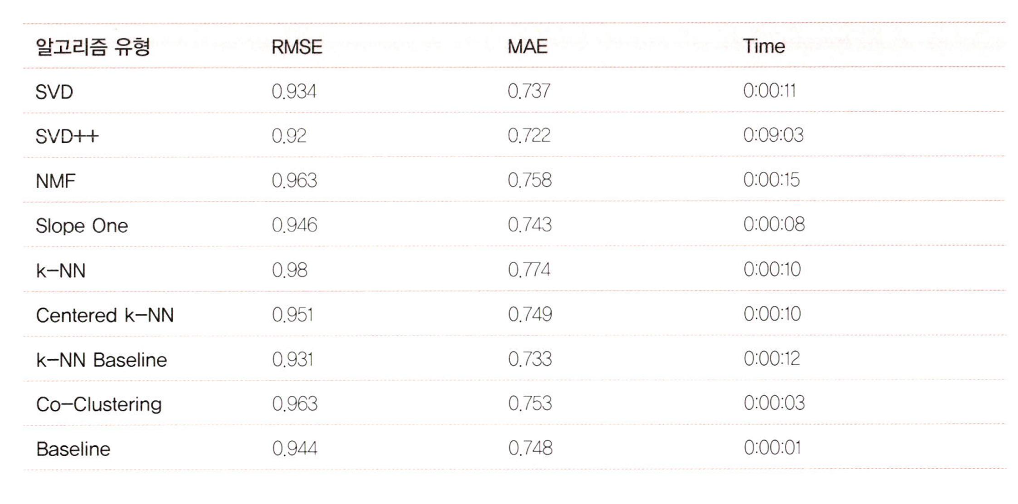

svd 알고리즘의 rmse mae 성적이 가장 좋지만 상대적으로 시간이 너무 오래걸려 데이터가 족므만 더 커져도 사용하기 어려울 것으로 보인다. knn 자체는 성능이 상대적으로 뒤지지만 bseline을 결합한 경우 성능평가 수치가 대폭 향상됐다. 베이스라인은 각 개인이 평점을 부여ㅎㅏ는 성향ㅇ르 반영해 평점을 계산한 것을 의미한다.

### 베이스라인 평점
개인의 성향에 따라 상품의 품질이 같더라도 평가가 달라질 수 있다. 이러한 개인의 성향을 반영해 아이템 평가에 편향성요소를 반영하여 평점을 부과하는 것을 베이스라인 평점이라 한다.

보통 전체평균평점 +사용자 편향 점수 + 아이템 편향 점수 공식으로 계산된다.

전체평균평점은 모든 사용자의 아이템에 디한 아이템의 평점을 평균한 값, 사용자편향점수: 사용자별 아이템 평점 평균 값 - 전체평균평점, 아이템 편향점수는 아이템볊 평점 평균값-전체평균평점을 의미한다.

영화평즘을 베이스라인 평점을 고려해 적용한다. 가령 모든 사용자의 평균적인 영화평점이 3.5이고 어벤져스 3편을 모든 사용자가 평균적으로 4.2라 평가했다면 영화평가를 늘 깐깐하게 하는 사용자 a는 어덯게 평가할지 계산해보자.

이는 사용자의 평균 영화평점 + 사용자편향점수(사용자의 전체영화평균평점 - 전체영화평균평점) + 아이템 편향점수로 계산할 수 있다.

### 교차검증과 하이퍼파라미터 튜닝

surprise는 교차검증과 하이퍼파라미터 튜닝을 위해 사이킷런과 유사한 cross validate와  gridsearchcv 클래스를 제공한다. 먼저 교차검증을 위한 cross validate 함수의 사용법부터 살펴보자. 해당 함수는 surprise model selection 모듈 내에 존재하며 폴드된 데이터세트의 개수와 성능 측정 방법을 명시해 교차검증ㅇ르 수핸한다.

다음 예제에서는 cross validatE를 이용해 ratings 를 데이터프레임으로 로딩한 데이터를 5개의 학습 검증 폴드 데이터 세트로 분리해 교차검증을 수행하고 rmse, mae로 성능평가를 진행한다.



In [ ]:
from surprise.model_selection import cross_validate

# pandas dataframe > surprise dataset
ratings =pd.read_csv('/content/drive/MyDrive/ESAA/OB/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId','rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo,data, measure=['RMSE', 'MAE'], cv=5, verbose=True)

cross validate는 위의 출력결과와 같이 폴드별 성능평가 수치와 전체 폴드의 평균 평가 수치를 함께 보여준다. surprise의 그리드서치도 사이킷런의 그리드서치와 유사하게 교차검증을 통한 하이퍼파라미터 최적화를 수행한다. 하이퍼파라미터 최적화는 알고리즘 유형에 따라 다르지만 svd의 경우 주로 점진적 하강 방식의 반복횟수를 지정하는 nepochs와 svd으 ㅣ잠재요인 ㅋ의 크기를 결정하는 nfactors를 튜닝한다. 

In [42]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs':[20,40,60], 'n_factors':[50,100,200]}
# cv를 3개의 폴드세트로 지정, 성능평가는 rmse,mse로 수행하도록 그리드서치구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse','mse'],cv=3)
gs.fit(data)

# best rmse score and that hyperparameter
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])



0.8774654638049375
{'n_epochs': 20, 'n_factors': 50}


### surprise를 이용한 개인화 영화 추천 시스템 구축

surprise를 이용해 잠재요인 협업 필터링 기반의 개인화된 영화추천을 구현해보자. 지금까지는 surprise가 학습데이터로 fit을 호출한 뒤 테스트데이터로 test를 호출해 예측 평점을 계산하고 mse/rmse로 평가하였다. 이제는 surprise 패키지로 학습된 추천알고리즘을 기반으로 특정 사용자가 아직 평점을 매기지 않은 영화중 개인츃야에 적절한영화를 천해보고자 한다. 

이번 예제에서는 Ratings 데이터를 학습 데이터와 테스트 데이터로 분리하지 않고 전체를 학습데이터로 사용한다. 그런데 이미 surprise에서는 데이터세트를 train test split으로 쪼개므로 trainset으로 변환하지 않으면 Fit으로ㅓ 학습할 수 없다.


```
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']],reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)
```

데이터 세트 전체를 학습데이ㅓㅌ로 사용하려면 datasetaufolds 클래스를 이용하면 datasetautofolds 객체를 생성한 뒤 vuild full trainset 메서드를 호출하여 전체데이터를 학습데이터세트로 만들 수 있따.

In [43]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format ='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
#datasetautofodls 클래스를 rating noh csv 파일 기반으로 생서이
data_folds = DatasetAutoFolds(ratings_file='/content/drive/MyDrive/ESAA/OB/ratings_noh.csv', reader=reader)

# 전체 데이터를 학습 데이터로 새성성
trainset = data_folds.build_full_trainset()

dataautofolds build full trainset메서드를 이용해 생성된 학습데이터를 ㅎ기반으로 핛브을 수핻ㅇ한다. 그리고 이후에 특정 사용자에 영화를 ㅜ천하기 위해 아직 보지않은 영화목록을 확인해보자. 먼저 svd를 이용해 학습을 수행하자1

In [44]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

특정 사용자는 user id=9로 지정한다. 간단히 패키지의 api를 샤용하여 userid9가 아직 평점을 매기지 않은 영화를 영화42로선정한 뒤 예측평점을 계산하자

In [45]:
# 영화에 대한 상세속성정보 데이터프레임 로딩
movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB/movies.csv')
#userid 9 의 movieid 데이터를 추출해 movieid42 데이터가 있는지 확인
movieIds = ratings[ratings['userId']==9]['movieId']

if movieIds[movieIds==42].count()==0:
  print('사용자 아이디 9는 영화아이디 42의 평점 없음')
print(movies[movies['movieId']==42])

사용자 아이디 9는 영화아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


movie id42 인 영화에 대해서 userid9 사용자의 추천 예상 평점은 predict 메서드를 이용하면 알 수 있다. 학습된 svd 객체에서 predict 메서드에서 movie id, userid 값을 입력해주면 된다.

In [46]:
uid = str(9)
iid = str(42) # 문자열값으로 입력해줘야함

pred=algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


추천예측평점값은 est값으로 3.13이다. 같은 방식으로 예측평점을 생성하여 예측평점 순으로 추천영화를 만들자. 먼저 추천대상이 되는 영화를 추출한다. surprise 내부의 데이터 객체에 대한 엑세스 제약등으로 인해 앞절에서 사용한 get unseen movies 대신 새롭게 만들어 영화정보를 반환하자

In [49]:
def get_unseen_surprise(ratings, movies, userId):
  seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()
  total_movies = movies['movieId'].tolist()

  unseen_movies =[movie for movie in total_movies if movie not in seen_movies]
  print('평점 매긴 영화 수:', len(seen_movies), '추천 영화 대상 수:', len(unseen_movies), '전체 영화 수 :', len(total_movies))
  return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)


평점 매긴 영화 수: 46 추천 영화 대상 수: 9696 전체 영화 수 : 9742


사용자아이디 9번은 전체 영화중에서 46개만 평점을 매겼다. 따라서 추천대상 영화는 전체 영화에서 4ㅅ6개를 제한 것으로 이 중 학습된 추천알고리즘 클래스인 svd 를 이용해 높은 예측 평점을 가진 순으로 영화를 추천해보자. 이를 recomm_movie_by_surprise 함수를 새롭게 생성한다. 이 함수는 인자로 핛브이 완료된 추천 알고리즘 객체, 추천대상 사용자아이디, 추천대상영화의 리스트 객체, 추천 상위 n개 개수를 받는다.

recomm_movie_by_surprise는 추천 대상 영화 모두를 대상으로 추천알고리즘 객체의 predict()메서드를 호출하고 그 결과인 prediction객체를 리스트 객체로 저장한다. 그리고 이렇게 저장된 리스트 내부의 prediction 객체를 예측평점이 높은 순으로 다시 정렬한 뒤 top-n개의 예측 객체에서 영화아이디, 영화제목, 예측 평점 정보를 추출해 반환한다.

In [ ]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):

  predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

  def sortkey_est(pred):
    return pred.est
  
  predictions.sort(key=sortkey_est, reverse=True)
  top_predictions = predictions[:top_n]

  top_movie_ids = [ int(pred.iid) for pred in top_predictions]
  top_movie_rating = [pred.est for pred in top_predictions]
  top_movie_titles = movies[movies.movieId.isin(top_movies_ids)['title']]

  top_movie_preds = [(id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

  return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)
print('####### top10 recommended movie list#######')
for top_movie in top_movie_preds:
  print(top_movie[1], ":", top_movie[2])